In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 8)

# Implicit Methods and Nonlinear Systems

## Nonlinear system

Consider the following nonlinear system:

$$
\frac{d}{dt} \left (
   \begin{array}{c} y_1 \\ y_2 \\ y_3 \end{array}
  \right ) =
%
\left (
 \begin{array}{rrr}
  -0.04 y_1 & + 10^4 y_2 y_3  & \\
   0.04 y_1 & - 10^4 y_2 y_3 & -3\times 10^7 y_2^2 \\
   &  & 3\times 10^7 y_2^2 
\end{array}
\right )
$$

The Jacobian is:

$$
{\bf J} = \left (
\begin{array}{ccc}
  -0.04 & 10^4 y_3 & 10^4 y_2 \\
   0.04 & -10^4 y_3 - 6\times 10^7 y_2 & -10^4 y_2 \\
   0 & 6\times 10^7 y_2 & 0 
\end{array}
\right )$$

(this example comes from the VODE documentation)

We'll use the intiial conditions

$$y_1(0) = 1, \, y_2(0) = y_3(0) = 0$$

This system has the longterm behavior that:

$$y_1, y_2 \rightarrow 0, \, y_3 \rightarrow 1$$

Although $y_2$ is initially 0, it will build up quickly and feed the creation of $y_3$.

## Linearization

Let's write our system as:

$$\dot{\bf y} = {\bf f}({\bf y})$$

We will discretize this as:

$${\bf y}^{n+1} = {\bf y}^n + \tau {\bf f}(t^{n+1}, {\bf y}^{n+1})$$

We will linearize the righthand side. We'll start with an initial guess for the new-time solution, ${\bf y}_0^{n+1}$, and seek a correction, $\Delta {\bf y}_0$ such that:

$${\bf y}^{n+1} = {\bf y}_0^{n+1} + \Delta {\bf y}_0$$

Now we insert this in ${\bf f}$ and Taylor expand:

$${\bf f}(t^{n+1},{\bf y}^{n+1}) = {\bf f}(t^{n+1}, {\bf y}_0^{n+1} )
   + \underbrace{ \left . \frac{\partial {\bf f}}{\partial {\bf y}} \right |_0}_{\equiv {\bf J}} \Delta {\bf y}_0 + \ldots$$
   
Our linearized system becomes:

$${\bf y}^{n+1} = {\bf y}^n + \tau \left [ {\bf f}(t^{n+1}, {\bf y}_0^{n+1}) + {\bf J}\Delta {\bf y}_0 \right ]$$

or in terms of the correction:

$$\left ( {\bf I} - \tau {\bf J} \right ) \Delta {\bf y}_0 = {\bf y}^n - {\bf y}_0^{n+1}
  + \tau {\bf f}(t^{n+1}, {\bf y}_0^{n+1})$$
  
This is a linear system that we can solve.  The basic idea will be:

* Apply the correction
* Check for convergence: $\| \Delta {\bf y} \| < \epsilon \| {\bf y}^n \|$
* Iterate, finding the next correction until we converge

## Backward Euler Implementation

First we need functions for the righthand side and Jacobian

In [2]:
def rhs(t, Y):
    """ RHS of the system -- using 0-based indexing """
    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]

    dy1dt = -0.04*y1 + 1.e4*y2*y3
    dy2dt =  0.04*y1 - 1.e4*y2*y3 - 3.e7*y2**2
    dy3dt =                         3.e7*y2**2

    return np.array([dy1dt, dy2dt, dy3dt])

def jac(t, Y):
    """ J_{i,j} = df_i/dy_j """

    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]
    
    df1dy1 = -0.04
    df1dy2 = 1.e4*y3
    df1dy3 = 1.e4*y2

    df2dy1 = 0.04
    df2dy2 = -1.e4*y3 - 6.e7*y2
    df2dy3 = -1.e4*y2

    df3dy1 = 0.0
    df3dy2 = 6.e7*y2
    df3dy3 = 0.0

    return np.array([ [ df1dy1, df1dy2, df1dy3 ],
                      [ df2dy1, df2dy2, df2dy3 ],
                      [ df3dy1, df3dy2, df3dy3 ] ])

Next we'll write the main driver.  This integrates from `[t, tmax]` using a timestep `dt_init`.  We specify a tolerance for the convergence of the nonlinear system solve for each step.

In [3]:
SMALL = 1.e-100

def backwards_euler(t, tmax, dt_init, y_init, rhs, jac,
                    tol=1.e-6, max_iter=100):
    """solve the system dy/dt = f(y), where f(y) is provided by the
    routine rhs(), and the Jacobian is provided by the routine jac().

      t : the current time
      tmax : the ending time of integration
      dt_init : initial timestep
      y_init : the initial conditions

    """

    time = t
    dt = dt_init

    # starting point of integration of each step
    y_n = np.zeros_like(y_init)
    y_n[:] = y_init[:]

    y_new = np.zeros_like(y_init)

    while time < tmax:

        converged = False

        # we want to solve for the updated y.  Set an initial guess to
        # the current solution.
        y_new[:] = y_n[:]

        err = 1.e30
        niter = 0
        
        neq = len(y_init)
        
        while err > tol and niter < max_iter:

            # construct the matrix A = I - dt J
            A = np.eye(neq) - dt * jac(time, y_n)

            # construct the RHS
            b = y_n - y_new + dt * rhs(time, y_new)

            # solve the linear system A dy = b
            dy = np.linalg.solve(A, b)

            # correct our guess
            y_new += dy

            # check for convergence
            err = np.linalg.norm(dy) / np.linalg.norm(y_new) #max(abs(y_new) + SMALL)
            niter += 1

        if time + dt > tmax:
            dt = tmax - time

        y_n[:] = y_new[:]
        time += dt

    return y_n

We'll follow the example from the VODE documentation and integrate in several chunks.  We'll evolve from $t = 0$ stopping at $t = 10^{-6}, 10^{-5}, \ldots 10^8$.  Each call to the integrator will begin with the time from the previous integration, and we'll always set $\tau$ to have ~10 steps per interval.

In [4]:
y_init = np.array([1.0, 0.0, 0.0])

# like the vode driver, we will do the integration in a bunch of
# pieces, increasing the stopping time by 10x each run
tends = np.logspace(-6, 8, 15)

time = 0.0
y_old = y_init.copy()

ys = []
for y in y_init:
    ys.append([y])

ts = [time]

total_be_solves = 0

for tmax in tends:

    y_new = backwards_euler(time, tmax, tmax/10, y_old, rhs, jac)

    time = tmax
    ts.append(time)
    for n, y in enumerate(y_new):
        ys[n].append(y)

    y_old[:] = y_new[:]

Now we can plot the 3 species

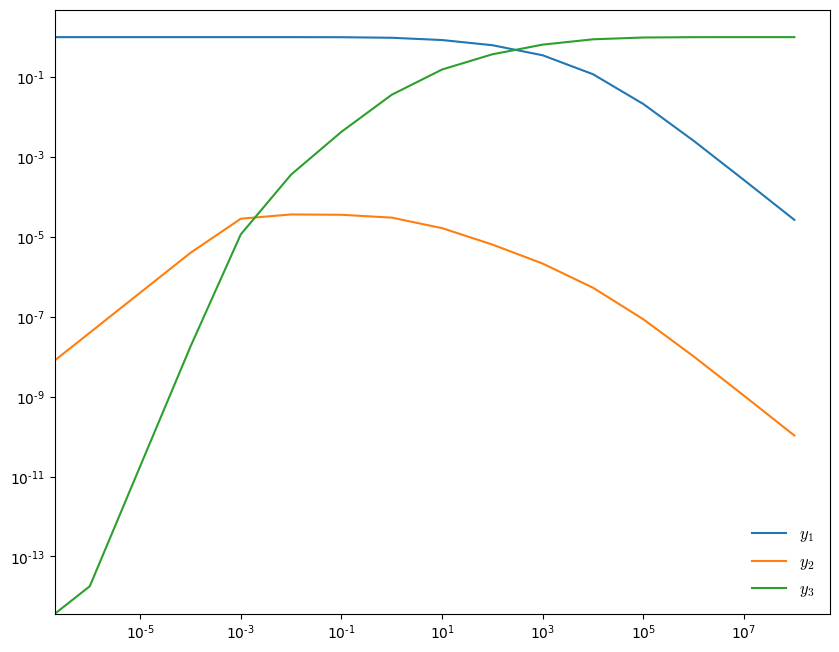

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

for n, y in enumerate(ys):
    ax.plot(ts, y, label=rf"$y_{n+1}$")

ax.legend(frameon=False, fontsize="large")
ax.set_xscale("log")
ax.set_yscale("log")

## Comparison of Methods

In [6]:
from scipy.integrate import solve_ivp

Now we can try integrating this system using any of the methods built into SciPy
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

We are successful if we try `BDF`, but we fail if we try the `RK45` method.  This is an emperical demonstration that this problem is stiff.

In [11]:
sol = solve_ivp(rhs, [0, 1.e8], [1, 0, 0], method="BDF", dense_output=True)

In [12]:
print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 443
     njev: 12
      nlu: 57
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f189add9f10>
   status: 0
  success: True
        t: array([0.00000000e+00, 3.19620663e-05, 6.39241326e-05, 3.83544795e-04,
       7.03165458e-04, 1.18036112e-03, 1.65755678e-03, 2.13475244e-03,
       2.92511851e-03, 3.71548457e-03, 4.50585063e-03, 5.29621670e-03,
       7.22442396e-03, 9.15263122e-03, 1.10808385e-02, 2.44842943e-02,
       3.78877502e-02, 8.58830350e-02, 1.33878320e-01, 1.81873605e-01,
       4.03737745e-01, 6.25601884e-01, 8.47466024e-01, 1.54569091e+00,
       2.24391579e+00, 2.94214068e+00, 3.64036556e+00, 4.38282460e+00,
       5.12528363e+00, 5.86774266e+00, 6.61020170e+00, 7.35266073e+00,
       9.22149134e+00, 1.10903220e+01, 1.29591526e+01, 1.48279832e+01,
       1.66968138e+01, 2.03704749e+01, 2.40441361e+01, 2.77177972e+01,
       3.13914583e+01, 3.67662258e+01, 4.214099